In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from scipy.special import expit
import pymc3 as pm
import arviz as az
import theano.tensor as tt

In [24]:
# Don't sting my eyes
%config InlineBackend.figure_format = 'retina'
sns.set()

Data accessible here: https://zenodo.org/record/845873#.WeDg9GhSw2x

In [25]:
df = pd.read_csv("data/cpc2018.csv")
df

,SubjID,Location,Gender,Age,Set,Condition,GameID,Ha,pHa,La,...,Trial,Button,B,Payoff,Forgone,RT,Apay,Bpay,Feedback,block
0,10100,Rehovot,M,28,1,ByProb,13,0,1.0,0,...,1,L,1,50,0,NaN,0,50,0,1
1,10100,Rehovot,M,28,1,ByProb,13,0,1.0,0,...,2,L,1,50,0,NaN,0,50,0,1
2,10100,Rehovot,M,28,1,ByProb,13,0,1.0,0,...,3,L,1,-50,0,NaN,0,-50,0,1
3,10100,Rehovot,M,28,1,ByProb,13,0,1.0,0,...,4,L,1,-50,0,NaN,0,-50,0,1
4,10100,Rehovot,M,28,1,ByProb,13,0,1.0,0,...,5,L,1,-50,0,NaN,0,-50,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510745,71109,Technion,M,24,7,ByProb,204,9,1.0,9,...,21,L,0,9,5,552.0,9,5,1,5
510746,71109,Technion,M,24,7,ByProb,204,9,1.0,9,...,22,L,0,9,5,355.0,9,5,1,5
510747,71109,Technion,M,24,7,ByProb,204,9,1.0,9,...,23,L,0,9,5,707.0,9,5,1,5
510748,71109,Technion,M,24,7,ByProb,204,9,1.0,9,...,24,L,0,9,5,493.0,9,5,1,5


* `SubjID`: Unique human subject identifier, made up of 5 digits. 1st digit marks the Set of games the subject faced (1-7), 2nd digit marks Location subject played in (0-1), last three digits have no meaning.

* `Location`: The physical location the subject was run in (“Technion”/“Rehovot”)
* `Gender`: Subject’s gender (M/F)
* `Age`: Subject’s age at time of experiment
* `Set`: ID for the set number that the subject faced (each set consists of the same 30 games). 1-5 are CPC15 data, 6-7 are CPC18’s Experiment 1 data.
* `Condition`: Legacy variable from CPC15 (“ByProb”/”ByFB”). Refers to the order condition by which subject saw the games within a set. CPC18 data will all be “ByProb” condition.
* `GameID`: Unique game (choice problem) identifier (1-210).
<< The next 12 variables define (jointly) the choice problem by defining the two possible distributions and any relationship between them. For more details on how each 12-tuple defines the exact distributions, see the paper >>
* `Ha`: Expected value of (High) lottery in Option A
* `pHa`: Probability to get payoff drawn from lottery in Option A
* `La`: Low payoff in Option A
* `LotShapeA`: Shape of lottery in Option A (“-“, “Symm”, “L-skew”, or “R-skew”) 
* `LotNumA`: Number of lottery outcomes in Option A
* `Hb`: Expected value of (High) lottery in Option B
* `pHb`: Probability to get payoff drawn from lottery in Option B
* `Lb`: Low payoff in Option B
* `LotShapeB`: Shape of lottery in Option B (“-“, “Symm”, “L-skew”, or “R-skew”)
* `LotNumB`: Number of lottery outcomes in Option B
* `Amb`: Whether Option B is ambiguous (i.e. its probabilities are not described to subjects;
Boolean)
* `Corr`: Whether payoffs generated by the two possible options are correlated and the sign of the correlation (-1/0/1)
* `Order`: The serial position of the current game within the sequence of 30 games the subject faced (1-30)
* `Trial`: The trial number within a game (1-25)
* `Button`: The on-screen side of the chosen button (“L”/”R”)
* `B`: The response variable. Whether or not the subject selected Option B in the current trial (Boolean)
* `Payoff`: The payoff the subject got from her/his choice in the current trial
* `Forgone`: The payoff the subject would have gotten had she/he selected the other option in the
current trial
* `RT`: Reaction time until choice of option (in milliseconds). Only measured for Sets 6, 7.
<< The next four variables can be computed directly from the previous variables. They are given for convenience. >>
* `APay`: The payoff provided by Option A in the current trial 
* `BPay`: The payoff provided by Option B in the current trial
* `Feedback`: Whether (full) feedback was provided for the subject regarding payoffs in the current trial
* `Block`: Number of time-block within the current game (each 5 trials define a block)

From Erev I, Ert E, Plonsky O, Cohen D, Cohen O. From anomalies to forecasts: Toward a descriptive model of decisions under risk, under ambiguity, and from experience. Psychol Rev. 2017 Jul;124(4):369-409. doi: 10.1037/rev0000062. Epub 2017 Mar 9. PMID: 28277716.

Accessible here: http://oriplonsky.com/wp-content/uploads/2017/09/Erev-et-al-2017.pdf

> The main properties of the problems in Table 1 include at least 11 dimensions.
Nine of the 11 dimensions can be described as parameters of the payoff distributions. These
parameters include: `LA`, `HA`, `pHA`, `LB`, `HB`, `pHB`, `LotNum`, `LotShape`, and `Corr`. In particular,
each problem in the space is a choice between Option A, which provides `HA` with probability
`pHA` or `LA` otherwise (with probability 1 − `pHA`), and Option B, which provides a lottery (that
has an expected value of `HB`) with probability `pHB`, and provides LB otherwise (with
probability 1 − `pHB`). The distribution of the lottery around its expected value (`HB`) is
determined by the parameters `LotNum` (which defines the number of possible outcomes in the 
lottery) and `LotShape` (which defines whether the distribution is symmetric around its mean,
right-skewed, left-skewed, or undefined if `LotNum` = 1), as explained in Appendix A. The
Corr parameter determines whether there is a correlation (positive, negative, or zero) between
the payoffs of the two options.
The tenth parameter, Ambiguity (`Amb`), captures the precision of the initial
information the decision maker receives concerning the probabilities of the possible
outcomes in Option B. We focus on the two extreme cases: `Amb` = 1 implies no initial
information concerning these probabilities (they are described with undisclosed fixed
parameters), and `Amb` = 0 implies complete information and no ambiguity (as in Allais, 1953;
Kahneman & Tversky, 1979).
The eleventh dimension in the space is the amount of feedback the decision maker
receives after making a decision. As Table 1 shows, some phenomena emerge in decisions
without feedback (i.e., decisions from description), and other phenomena emerge when the
decision maker can rely on feedback (i.e., decisions from experience). We studied this
dimension within problem. That is, decision makers faced each problem first without
feedback, and then with full feedback (i.e., realization of the obtained and forgone outcomes
following each choice).

In [26]:
len(df.SubjID.unique())

686

In [27]:
(df.Amb == 0).sum()

443000

In [28]:
sorted(df.pHb.unique())

[0.01, 0.05, 0.1, 0.2, 0.25, 0.4, 0.5, 0.6, 0.75, 0.8, 0.9, 0.95, 0.99, 1.0]

In [29]:
sorted(df.pHa.unique())

[0.01, 0.05, 0.1, 0.2, 0.25, 0.4, 0.5, 0.6, 0.75, 0.8, 0.9, 0.95, 0.99, 1.0]

In [30]:
print(sorted(df.Ha.unique()))

[-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 36, 37, 39, 41, 42, 43, 44, 45, 46, 49, 50, 51, 52, 53, 58, 60, 65, 67, 68, 71, 72, 74, 76, 83, 85, 87, 92, 94, 104]


In [31]:
print(sorted(df.La.unique()))

[-47, -41, -40, -39, -38, -37, -36, -33, -29, -27, -26, -24, -22, -20, -18, -17, -16, -14, -13, -11, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [32]:
print(sorted(df.Hb.unique()))

[-11, -10, -5, -4, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 57, 59, 60, 61, 64, 65, 68, 70, 71, 73, 75, 76, 77, 79, 80, 82, 84, 88, 90, 91, 92, 93, 97, 100, 101, 102, 103, 112, 116]


In [33]:
print(sorted(df.Lb.unique()))

[-50, -49, -46, -45, -44, -43, -40, -37, -36, -35, -34, -33, -32, -31, -30, -29, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 36]


In [34]:
data = df[(df.LotNumB == 1) & (df.LotNumA == 1) & (df.Amb == 0) 
          & (df.Ha >= 0) & (df.Hb >= 0) & (df.La >= 0) & (df.Lb >= 0)]  # & (df.La ==0)  & (df.Lb == 0)
data

,SubjID,Location,Gender,Age,Set,Condition,GameID,Ha,pHa,La,...,Trial,Button,B,Payoff,Forgone,RT,Apay,Bpay,Feedback,block
25,10100,Rehovot,M,28,1,ByProb,25,2,1.0,2,...,1,R,0,2,1,NaN,2,1,0,1
26,10100,Rehovot,M,28,1,ByProb,25,2,1.0,2,...,2,R,0,2,3,NaN,2,3,0,1
27,10100,Rehovot,M,28,1,ByProb,25,2,1.0,2,...,3,R,0,2,3,NaN,2,3,0,1
28,10100,Rehovot,M,28,1,ByProb,25,2,1.0,2,...,4,R,0,2,1,NaN,2,1,0,1
29,10100,Rehovot,M,28,1,ByProb,25,2,1.0,2,...,5,R,0,2,3,NaN,2,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510395,71109,Technion,M,24,7,ByProb,186,19,1.0,19,...,21,L,0,19,5,405.0,19,5,1,5
510396,71109,Technion,M,24,7,ByProb,186,19,1.0,19,...,22,L,0,19,5,470.0,19,5,1,5
510397,71109,Technion,M,24,7,ByProb,186,19,1.0,19,...,23,L,0,19,5,367.0,19,5,1,5
510398,71109,Technion,M,24,7,ByProb,186,19,1.0,19,...,24,L,0,19,5,499.0,19,5,1,5


In [35]:
print(sorted(data.pHa.unique()))
print(sorted(data.pHb.unique()))

print(sorted(data.Ha.unique()))

print(sorted(data.La.unique()))

print(sorted(data.Hb.unique()))

print(sorted(data.Lb.unique()))

[0.01, 0.1, 0.25, 0.5, 0.6, 0.95, 1.0]
[0.01, 0.05, 0.1, 0.2, 0.25, 0.4, 0.5, 0.6, 0.75, 0.8, 0.9, 0.95, 1.0]
[1, 2, 3, 6, 7, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 28, 30, 32, 39, 51, 53, 60, 85]
[0, 1, 2, 3, 4, 7, 9, 10, 13, 14, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 30]
[2, 3, 4, 6, 8, 9, 12, 16, 20, 21, 32, 33, 34, 35, 38, 41, 42, 43, 44, 45, 48, 50, 54, 59, 64, 65, 70, 90, 97, 100, 101]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 16, 17, 19, 23, 24, 28, 36]


In [36]:
data = data.drop(['Location', 'Condition', 'GameID', 'Set', 'Gender', 'Age', 'Amb', 'RT', 
                                'Button', 'LotShapeA', 'LotShapeB','Corr', 'block'], axis=1)
data

,SubjID,Ha,pHa,La,LotNumA,Hb,pHb,Lb,LotNumB,Order,Trial,B,Payoff,Forgone,Apay,Bpay,Feedback
25,10100,2,1.0,2,1,3,0.5,1,1,2,1,0,2,1,2,1,0
26,10100,2,1.0,2,1,3,0.5,1,1,2,2,0,2,3,2,3,0
27,10100,2,1.0,2,1,3,0.5,1,1,2,3,0,2,3,2,3,0
28,10100,2,1.0,2,1,3,0.5,1,1,2,4,0,2,1,2,1,0
29,10100,2,1.0,2,1,3,0.5,1,1,2,5,0,2,3,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510395,71109,19,1.0,19,1,97,0.1,5,1,16,21,0,19,5,19,5,1
510396,71109,19,1.0,19,1,97,0.1,5,1,16,22,0,19,5,19,5,1
510397,71109,19,1.0,19,1,97,0.1,5,1,16,23,0,19,5,19,5,1
510398,71109,19,1.0,19,1,97,0.1,5,1,16,24,0,19,5,19,5,1


In [41]:
data = pd.DataFrame({
    "id": data.SubjID,
    "pA": data.pHa.values,
    "xA0": data.Ha.values,
    "xA1": data.La.values,
    "pB": data.pHb.values,
    "xB0": data.Hb.values,
    "xB1": data.Lb.values,
    "y": data.B.values
})

In [42]:
data

,id,pA,xA0,xA1,pB,xB0,xB1,y
25,10100,1.0,2,2,0.5,3,1,0
26,10100,1.0,2,2,0.5,3,1,0
27,10100,1.0,2,2,0.5,3,1,0
28,10100,1.0,2,2,0.5,3,1,0
29,10100,1.0,2,2,0.5,3,1,0
...,...,...,...,...,...,...,...,...
510395,71109,1.0,19,19,0.1,97,5,0
510396,71109,1.0,19,19,0.1,97,5,0
510397,71109,1.0,19,19,0.1,97,5,0
510398,71109,1.0,19,19,0.1,97,5,0


In [43]:
print(sorted(data.pA.unique()))
print(sorted(data.pB.unique()))

print(sorted(data.xA0.unique()))

print(sorted(data.xA1.unique()))

print(sorted(data.xB0.unique()))

print(sorted(data.xB1.unique()))

[0.01, 0.1, 0.25, 0.5, 0.6, 0.95, 1.0]
[0.01, 0.05, 0.1, 0.2, 0.25, 0.4, 0.5, 0.6, 0.75, 0.8, 0.9, 0.95, 1.0]
[1, 2, 3, 6, 7, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 28, 30, 32, 39, 51, 53, 60, 85]
[0, 1, 2, 3, 4, 7, 9, 10, 13, 14, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 30]
[2, 3, 4, 6, 8, 9, 12, 16, 20, 21, 32, 33, 34, 35, 38, 41, 42, 43, 44, 45, 48, 50, 54, 59, 64, 65, 70, 90, 97, 100, 101]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 16, 17, 19, 23, 24, 28, 36]


In [46]:
data.id.value_counts()

11303    325
10113    325
10316    325
11603    325
11020    325
        ... 
70095     50
71097     50
70106     50
71092     50
71045     25
Name: id, Length: 686, dtype: int64

In [47]:
data.id.value_counts().min(), data.id.value_counts().max()

(25, 325)

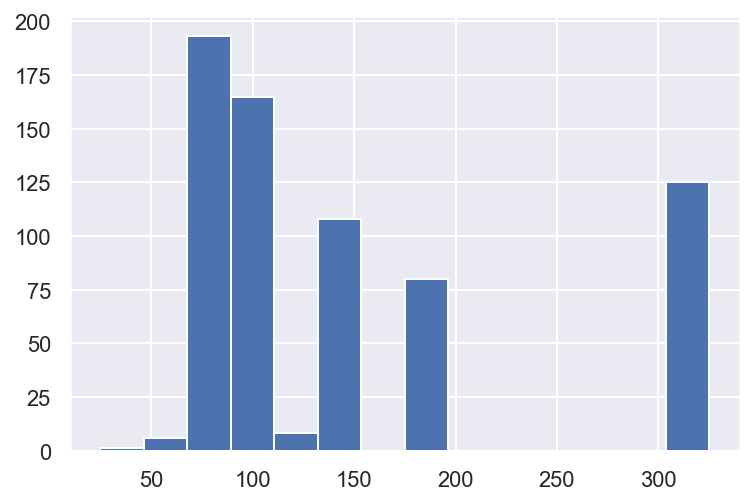

In [49]:
plt.hist(data.id.value_counts(), bins="auto");